# Single-cell Enrichment Analysis

Single-cell RNA-seq (scRNA-seq) yields many molecular readouts that are hard to interpret
by themselves.
One common approach to summarize this data is to compute enrichment scores using
predefined gene sets based on prior biological knowledge.

In this notebook, we demonstrate how to use `decoupler` to infer transcription factor
(TF) and pathway enrichment scores from a scRNA-seq human dataset.

The dataset includes 3k peripheral blood mononuclear cells (PBMCs) from a healthy donor.
It publicly available at the 10x Genomics
[webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k).

<div class="alert alert-info">

**Note**
    
When your data consist of different conditions with multiple samples (patients,
mice, etc.), it is recommended to use pseudobulk profiles instead

</div>

## Loading Packages

In [1]:
import scanpy as sc
import decoupler as dc

sc.set_figure_params(figsize=(3, 3), frameon=False)

## Loading The Dataset

In [2]:
adata = dc.ds.pbmc3k()
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts', 'celltype', 'leiden'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    obsp: 'distances', 'connectivities'

The obtained {class}`anndata.AnnData` consist of log-normalized transcript counts for ~3k cells
with measurements for ~15k genes.

The cell metadata stored in {attr}`anndata.AnnData.obs` can be inspected.

In [3]:
adata.obs

,n_genes,percent_mito,n_counts,celltype,leiden
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,Clust:0
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,Clust:2
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,Clust:0
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,Clust:1
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,Clust:4
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,Clust:1
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,Clust:2
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,Clust:2


And visualized.

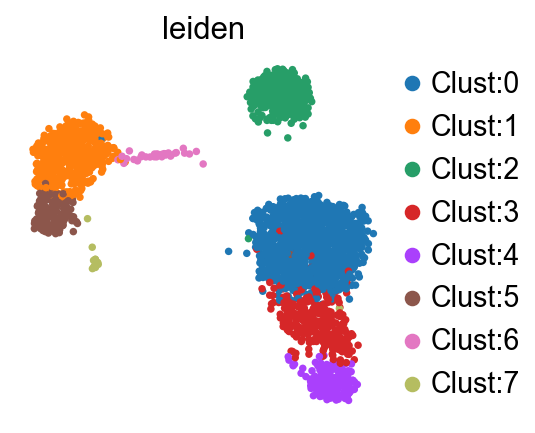

In [4]:
sc.pl.umap(
    adata=adata,
    color="leiden",
)

## Enrichment analysis

Enrichment analysis tests whether a specific set of omics features is "overrepresented" or "coordinated"
in the measured data compared to a background distribution. These sets are predefined based on existing
biological knowledge and may vary depending on the omics technology used.

Enrichment analysis requires the use of an enrichment method, and several options are available.
In the original manuscript of `decoupler` {cite:p}`decoupler`, we benchmarked multiple methods
and found that the univariate linear model (`ulm`) outperformed the others. Therefore, we will use
`ulm` in this vignette. 

The scores from {func}`decoupler.mt.ulm` should be interpreted such that larger magnitudes indicate
greater significance, while the sign reflects whether the features in the set are overrepresented
(positive) or underrepresented (negative) compared to the background.

### Cell type scoring based on marker genes

In single-cell analysis, there is no measured readout that directly informs about the cell type of each individual
cell. To assign cell type labels, cells are first projected into a shared embedded space. Through clustering, groups of
cells with similar transcriptional profiles are then identified, and the expression of known cell
type-specific markers are used to annotate the cells. These markers, identified and annotated in previous studies, are
collected and curated in various reference resources. When multiple marker genes are available, enrichment
methods can be used to score marker sets within cells, providing guidance for annotating the
resulting clusters.

#### PanglaoDB
[PanglaoDB](https://panglaodb.se/) {cite:p}`panglaodb` is a database that compiles and annotates cell type markers across
multiple tissues.
It can be conveniently accessed through the [OmniPath](https://omnipathdb.org/) module of `decoupler` {cite:p}`omnipath`.

<div class="alert alert-info">

**Note**
    
Other cell marker databases are avaliable, such as `CellTypist`,
which can be accessed with the same function
`decoupler.op.resource`

</div>

In [5]:
markers = dc.op.resource("PanglaoDB", organism="human")
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
,,,,,,,,,,,,,
0,A0A068BD53,True,B cells,Mesoderm,False,0.000000,0.000000,True,0.391473,0.002740,10090,Immune system,0.007
1,A0A068BGV1,True,Dendritic cells,Mesoderm,False,0.000000,0.000000,True,0.142857,0.000193,10090,Immune system,0.000
2,A0A068BGW6,True,B cells,Mesoderm,False,0.000000,0.000000,True,0.391473,0.002740,10090,Immune system,0.007
3,A0A087WRN7,False,Salivary mucous cells,Ectoderm,False,NaN,NaN,True,NaN,NaN,10090,Oral cavity,0.001
4,A0A0F6QAG2,True,NK cells,Mesoderm,False,0.000000,0.000000,True,0.372340,0.000129,10090,Immune system,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,ZNF521,False,Adipocyte progenitor cells,Mesoderm,True,0.000000,0.010338,False,0.000000,0.000000,9606,Connective tissue,0.002
8457,ZNRF4,False,Germ cells,Mesoderm,True,0.284360,0.000000,True,0.000000,0.000000,9606,Reproductive,0.010
8458,ZPBP2,True,Germ cells,Mesoderm,True,0.436019,0.000000,True,0.000000,0.000000,9606,Reproductive,0.008


Since the dataset consists of human cells and high-quality markers are preferred,
the markers can be filtered to retain only those labeled as canonical and specific to human.

We also format the network of gene sets into the decoupler format: `source`, `target`

In [6]:
# Filter by canonical_marker and human
markers = markers[
    markers["human"].astype(bool)
    & markers["canonical_marker"].astype(bool)
    & (markers["human_sensitivity"].astype(float) > 0.5)
]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

# Format
markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]
markers

,source,target
,,
50,Pulmonary alveolar type II cells,ABCA3
122,Enterocytes,ACSL5
133,Smooth muscle cells,ACTA2
144,Myoepithelial cells,ACTG2
145,Smooth muscle cells,ACTG2
...,...,...
8341,Endothelial cells,VWF
8350,Luminal epithelial cells,WFDC2
8351,Ductal cells,WFDC2


In this tutorial, these markers will be used, but any gene collection could be applied, including custom gene sets.

#### Scoring
We can easily compute cell type enrichment scores by running the `ulm` method.

In [7]:
dc.mt.ulm(data=adata, net=markers, tmin=3)

The obtained scores (`score_ulm`) and adjusted p-values (`padj_ulm`) were stored in the `adata.obsm` keys.

In [8]:
adata.obsm["score_ulm"]

,Acinar cells,Adipocytes,Alpha cells,B cells,B cells naive,Dendritic cells,Ductal cells,Endothelial cells,Enterocytes,Ependymal cells,...,Pancreatic stellate cells,Pericytes,Plasma cells,Plasmacytoid dendritic cells,Platelets,Podocytes,Proximal tubule cells,Pulmonary alveolar type II cells,Smooth muscle cells,T cells
AAACATACAACCAC-1,-0.574614,0.880015,1.501143,4.869608,3.822776,7.993952,-0.406252,-0.908959,-0.454221,-0.406252,...,-0.351811,1.501143,3.070459,0.325694,4.707824,-0.574614,-0.574614,-0.497593,-0.454221,13.437334
AAACATTGAGCTAC-1,-0.752534,-0.266765,0.907750,10.639314,12.676054,14.592025,2.193505,0.266856,0.217661,-0.532039,...,-0.460741,2.193505,6.653792,1.056778,3.699963,-0.752534,-0.752534,-0.651663,-0.594861,3.827107
AAACATTGATCAGC-1,-0.717204,0.775482,1.195078,3.379488,6.287648,7.469071,-0.507061,-0.018701,-0.566934,-0.507061,...,-0.439111,2.715337,1.806525,-0.318529,6.199206,-0.717204,0.042273,-0.621069,-0.566934,15.211887
AAACCGTGCTTCCG-1,0.614963,2.143531,0.671311,8.120865,4.465337,26.901402,1.338112,0.568580,-0.523795,0.671311,...,-0.405698,0.671311,4.233656,0.420052,7.887647,0.143440,-0.662630,-0.573810,-0.523795,5.473293
AAACCGTGTATGCG-1,-0.498060,-0.556890,1.495823,2.115894,0.170480,15.537294,-0.352129,0.039016,-0.393707,-0.352129,...,-0.304941,-0.352129,0.703835,3.160296,6.316497,-0.498060,-0.498060,-0.431300,-0.393707,3.873352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1.131347,1.491715,1.096136,7.689370,3.972790,26.218950,2.529991,1.203758,-0.569493,-0.509350,...,-0.441093,2.702240,4.672744,1.096436,5.488147,-0.720441,-0.720441,-0.623872,-0.569493,5.171710
TTTCTACTGAGGCA-1,-0.745205,-0.833229,1.081317,9.558244,5.570785,12.581891,2.096218,-0.270738,-0.589067,-0.526857,...,-0.456254,2.984098,13.259767,2.046399,5.558045,-0.745205,-0.745205,-0.645316,-0.589067,2.361846
TTTCTACTTCCTCG-1,-0.525565,-0.587644,1.020571,15.879073,15.877780,17.799659,-0.371575,-0.831368,-0.415449,-0.371575,...,-0.321781,-0.371575,8.865448,1.326769,4.018225,-0.525565,-0.525565,-0.455119,-0.415449,4.885653
TTTGCATGAGAGGC-1,-0.459498,-0.513773,-0.324865,20.431676,15.533753,19.685476,-0.324865,-0.726856,-0.363224,-0.324865,...,-0.281331,-0.324865,8.988557,1.406361,4.553272,-0.459498,-0.459498,-0.397907,-0.363224,5.776182


To visualize the obtained scores, we can re-use many of `scanpy`’s plotting functions.
First though, we need to extract them from the `adata` object.

In [9]:
score = dc.pp.get_obsm(adata, key="score_ulm")
score

AnnData object with n_obs × n_vars = 2638 × 36
    obs: 'n_genes', 'percent_mito', 'n_counts', 'celltype', 'leiden'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'leiden_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'score_ulm', 'padj_ulm'

{func}`decoupler.pp.get_obsm` returns a new {class}`anndata.AnnData` object which holds the obtained
activities in its {attr}`anndata.AnnData.X` attribute.

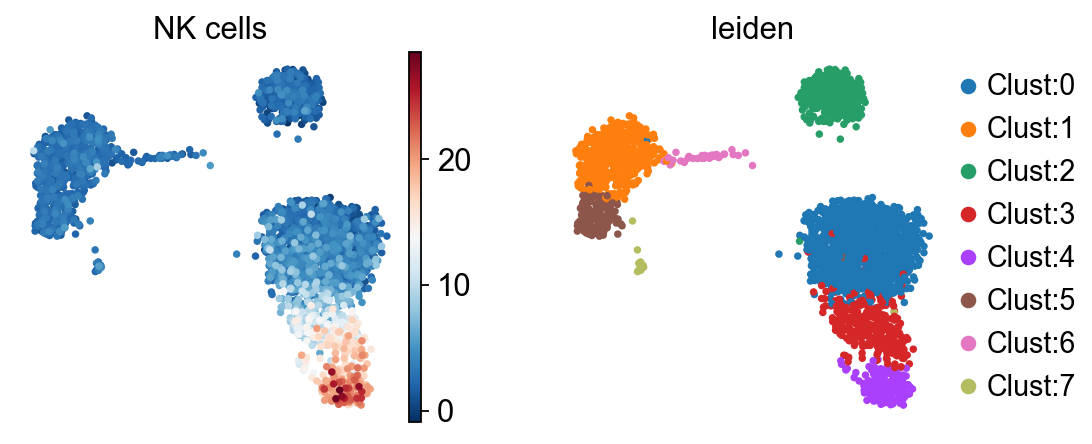

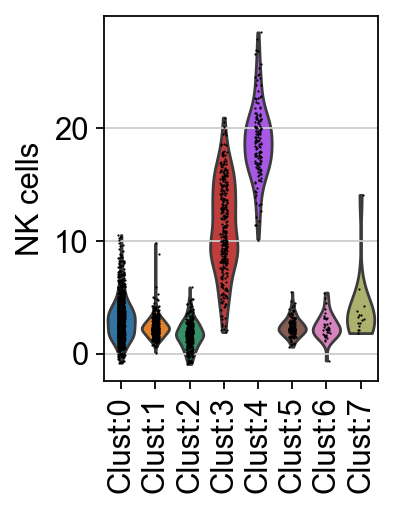

In [10]:
sc.pl.umap(score, color=["NK cells", "leiden"], cmap="RdBu_r")
sc.pl.violin(score, keys=["NK cells"], groupby="leiden", rotation=90)

The highlighted cells appear to be enriched for NK cell marker genes, with most of them belonging to cluster 4 or 3.

With `decoupler`, the top predicted cell types per cluster can also be identified using
the function {func}`decoupler.tl.rankby_group`.
This function identifies "marker" cell types per cluster using the same statistical tests available in
{func}`scanpy.tl.rank_genes_groups`.

In [11]:
df = dc.tl.rankby_group(adata=score, groupby="leiden", reference="rest", method="t-test_overestim_var")
df = df[df["stat"] > 0]
df

,group,reference,name,stat,meanchange,pval,padj
1,Clust:0,rest,T cells,38.206923,4.718293,5.308180e-247,9.554725e-246
22,Clust:0,rest,Neurons,6.885109,0.195677,7.446037e-12,1.165467e-11
23,Clust:0,rest,Erythroid-like and erythroid precursor cells,6.733126,0.211885,2.096498e-11,3.144747e-11
27,Clust:0,rest,Oligodendrocytes,3.551632,0.077581,3.905947e-04,5.021931e-04
28,Clust:0,rest,Pericytes,3.514299,0.194079,4.497034e-04,5.582525e-04
...,...,...,...,...,...,...,...
282,Clust:7,rest,Gamma delta T cells,0.438223,0.729249,6.656753e-01,7.730423e-01
283,Clust:7,rest,Alpha cells,0.297565,0.133760,7.682714e-01,8.285775e-01
285,Clust:7,rest,Neurons,0.278680,0.067593,7.825454e-01,8.285775e-01
286,Clust:7,rest,Luminal epithelial cells,0.220853,0.123104,8.268214e-01,8.504448e-01


The top 3 predicted cell types per cluster can then be extracted.

In [12]:
n_ctypes = 3
ctypes_dict = df.groupby("group").head(n_ctypes).groupby("group")["name"].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'Clust:0': ['T cells',
  'Neurons',
  'Erythroid-like and erythroid precursor cells'],
 'Clust:1': ['Neutrophils', 'Monocytes', 'Dendritic cells'],
 'Clust:2': ['B cells', 'B cells naive', 'Plasma cells'],
 'Clust:3': ['NK cells', 'Gamma delta T cells', 'T cells'],
 'Clust:4': ['Gamma delta T cells',
  'NK cells',
  'Plasmacytoid dendritic cells'],
 'Clust:5': ['Macrophages', 'Dendritic cells', 'Monocytes'],
 'Clust:6': ['Dendritic cells', 'Luminal epithelial cells', 'Ductal cells'],
 'Clust:7': ['Platelets', 'Endothelial cells', 'Hepatic stellate cells']}

The obtained top predicted cell types can be visualized.

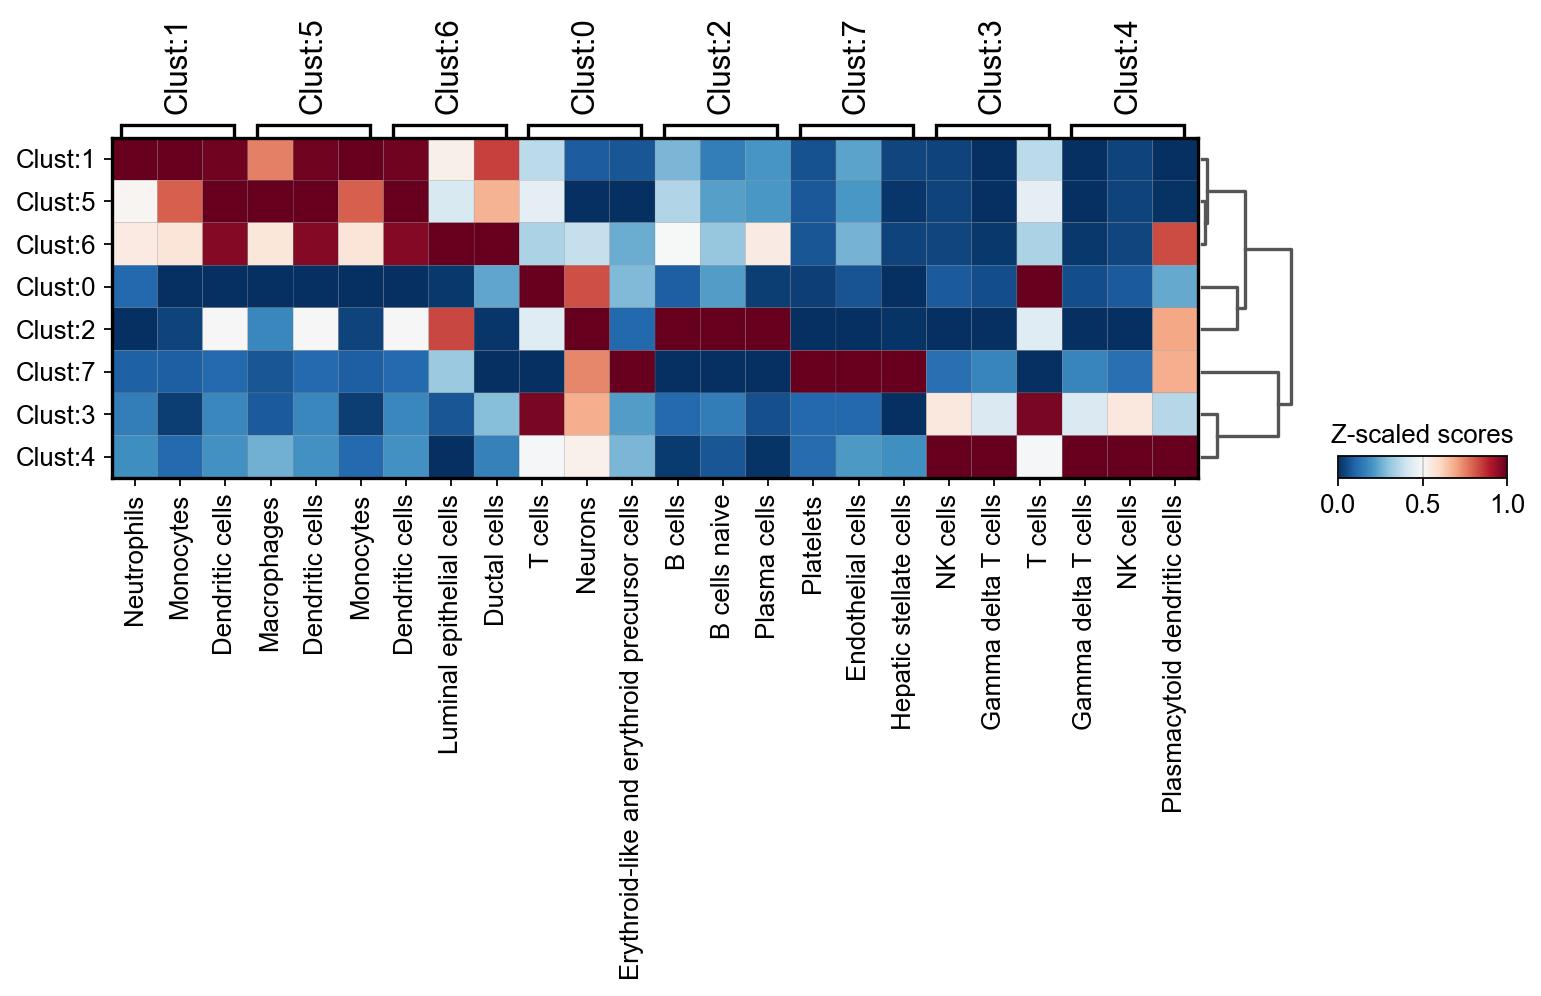

In [13]:
sc.pl.matrixplot(
    adata=score,
    var_names=ctypes_dict,
    groupby="leiden",
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
)

The plot reveals that cluster 7 corresponds to Platelets, cluster 4 appears to be NK cells,
clusters 0 and 3 may represent T-cells, cluster 2 is likely a form of B cells, and clusters
6, 5, and 1 belong to the myeloid lineage.

Individual cell types can be examined by plotting their distributions.sc.pl.violin(acts, keys=['T cells', 'B cells', 'Platelets', 'Monocytes', 'NK cells'], groupby='leiden')


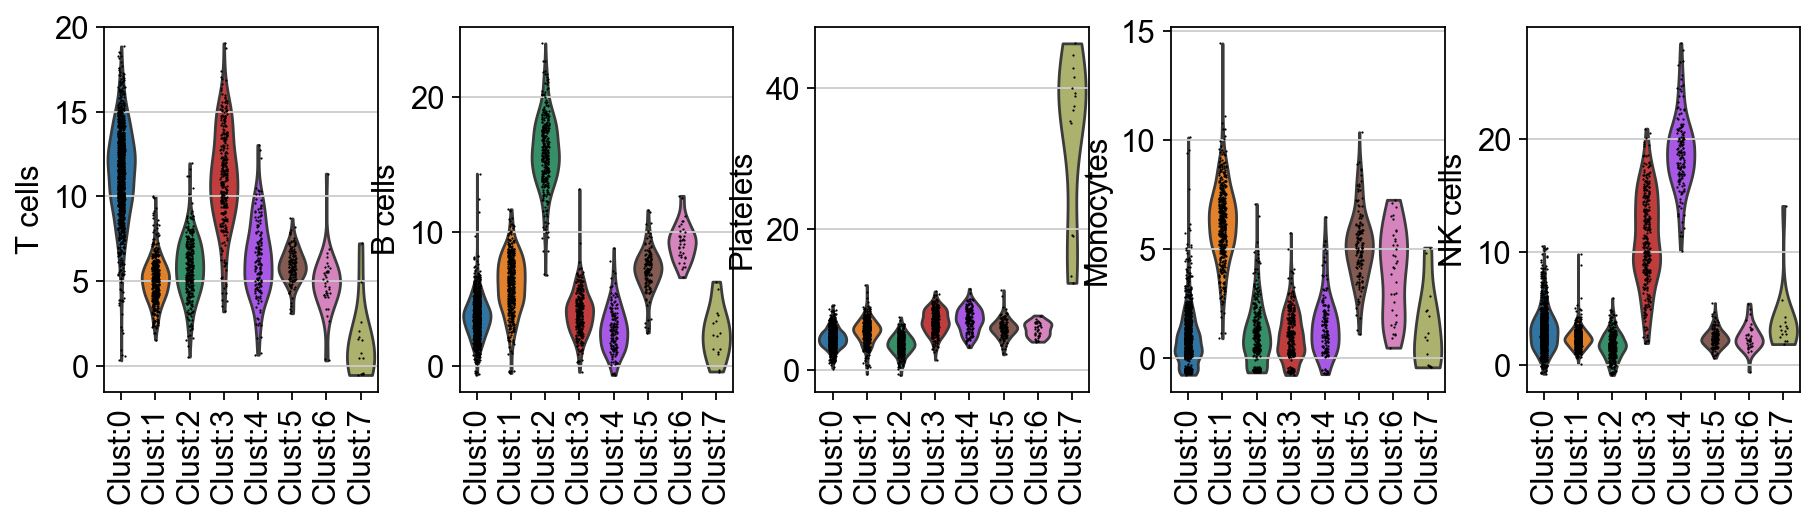

In [14]:
sc.pl.violin(
    adata=score,
    keys=["T cells", "B cells", "Platelets", "Monocytes", "NK cells"],
    groupby="leiden",
    rotation=90,
)

Final annotation should be performed manually based on the interpretation of enrichment results.
However, an automatic prediction can be generated by assigning the top predicted cell type to
each cluster. Although this approach does not require tissue-specific expertise, it may lead to
inaccuracies. Nevertheless, it can serve as a useful starting point.

In [15]:
dict_ann = df[df["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()
dict_ann

{'Clust:0': 'T cells',
 'Clust:2': 'B cells',
 'Clust:1': 'Neutrophils',
 'Clust:4': 'Gamma delta T cells',
 'Clust:3': 'NK cells',
 'Clust:5': 'Macrophages',
 'Clust:6': 'Dendritic cells',
 'Clust:7': 'Platelets'}

Once the top cell type has been selected for each cluster, annotation can be performed.

In [16]:
# Update cats
adata.obs["leiden"] = adata.obs["leiden"].cat.rename_categories(dict_ann)

In this case, the predicted annotations can also be compared to the known reference annotations

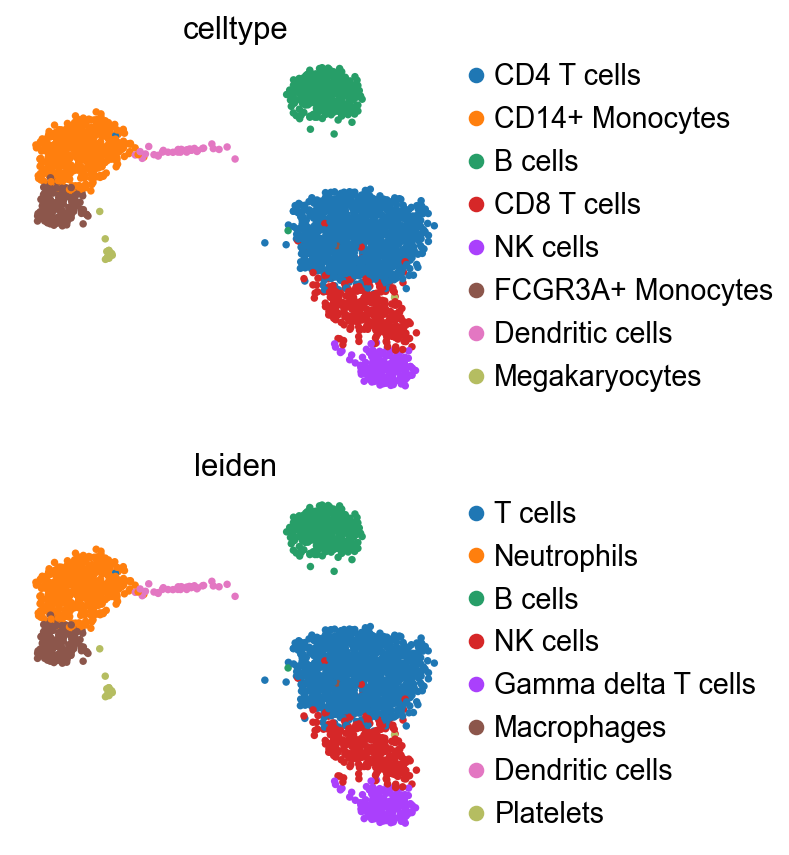

In [17]:
sc.pl.umap(
    adata=adata,
    color=["celltype", "leiden"],
    ncols=1,
)

Compared to the original annotation from the `scanpy` tutorial {cite:p}`scanpy`, the results are largely similar,
though some discrepancies are present, highlighting the limitations of automatic annotation.

While automatic methods are effective for identifying general lineages, they may be less reliable
when distinguishing specific cell type subsets.

Therefore, cell annotation should always be reviewed by a domain expert familiar with the tissue of interest.
This section only illustrates how to generate an initial draft annotation.
The remainder of the tutorial will use the reference annotations.

### Transcription factor scoring from gene regulatory networks

Transcription factors (TFs) are genes that, once translated into proteins, bind to DNA and regulate
the expression of other genes by either promoting or inhibiting their transcription. Gene
Regulatory Networks (GRNs) capture these TF-gene interactions and can be constructed from prior
knowledge or inferred from omics data. The fundamental unit of a GRN is a TF and its associated target
genes, collectively known as a *regulon*. Each regulon functions as a gene set in enrichment analysis.

Although TFs are measured in transcriptomic data, their transcript levels often do not reflect their actual
activity in a given cell. Instead, scoring TFs through enrichment analysis based on the expression of
their target genes provides a more accurate representation of their regulatory activity
{cite:p}`grn_review`.

#### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource containing a curated
collection of TFs and their transcriptional targets compiled from 12 different resources {cite:p}`collectri`. This collection
provides an increased coverage of transcription factors and a superior performance in identifying perturbed
TFs compared to other literature based GRNs such as 
[DoRothEA](https://saezlab.github.io/dorothea/) {cite:p}`dorothea`.
Similar to DoRothEA, interactions are weighted by their mode of regulation
(activation or inhibition).

In this tutorial we will use the human version but other organisms are available.
We can use `decoupler` to retrieve it from the [OmniPath](https://omnipathdb.org/) server {cite:p}`omnipath`.

<div class="alert alert-info">

**Note**

In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 
</div> 

In [18]:
collectri = dc.op.collectri(organism="human")
collectri

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
...,...,...,...,...,...,...
42985,NFKB,hsa-miR-143-3p,1.0,ExTRI,19472311,default activation
42986,AP1,hsa-miR-206,1.0,ExTRI;GEREDB;NTNU.Curated,19721712,PMID
42987,NFKB,hsa-miR-21,1.0,ExTRI,20813833;22387281,default activation
42988,NFKB,hsa-miR-224-5p,1.0,ExTRI,23474441;23988648,default activation


#### Scoring
TF scores can be easily computed by running the `ulm` method.

In [19]:
dc.mt.ulm(data=adata, net=collectri)

Scores can be then extracted.

In [20]:
score = dc.pp.get_obsm(adata=adata, key="score_ulm")
score

AnnData object with n_obs × n_vars = 2638 × 606
    obs: 'n_genes', 'percent_mito', 'n_counts', 'celltype', 'leiden'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'leiden_colors', 'dendrogram_leiden', 'celltype_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'score_ulm', 'padj_ulm'

And visualized.

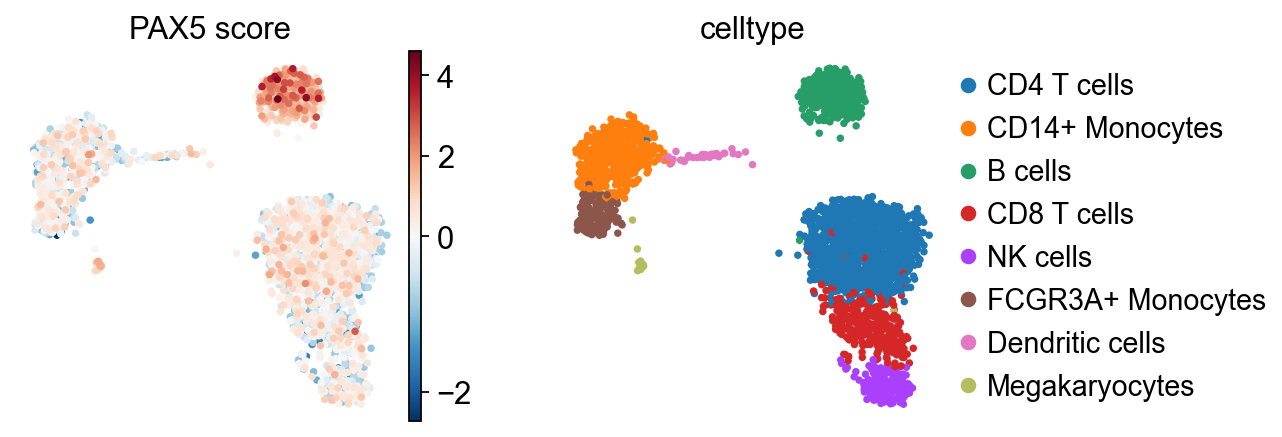

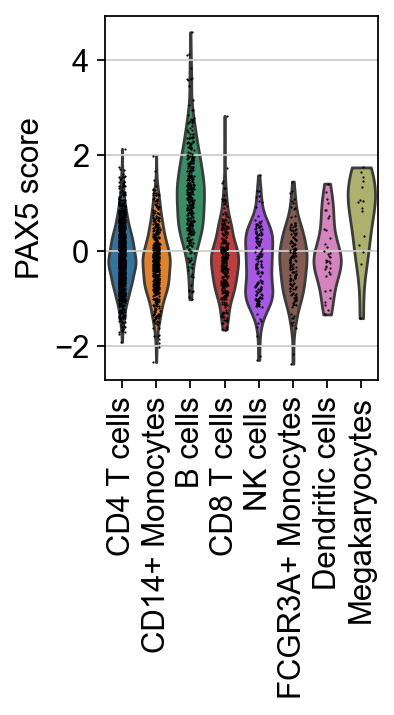

In [21]:
tf = "PAX5"
sc.pl.umap(score, color=[tf, "celltype"], cmap="RdBu_r", vcenter=0, title=[f"{tf} score", "celltype"])
sc.pl.violin(score, keys=[tf], groupby="celltype", rotation=90, ylabel=f"{tf} score")

Here, the inferred activity of PAX5 across cells is shown, with particularly high activity in B cells.
Notably, PAX5 is a well-established TF essential for B cell identity and function {cite:p}`pax5`.

As previously noted, TF expression alone is not a reliable proxy for its activity.
For instance, although PAX5 is known to be active in B cells, its expression is detected in only a
limited number of cells in this dataset. This highlights the importance of using TF enrichment scores.

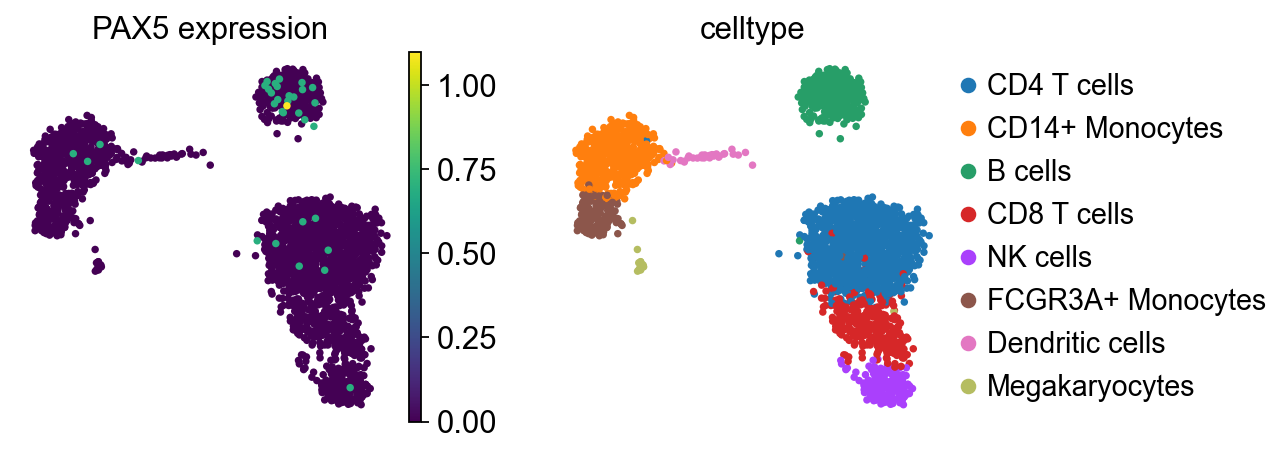

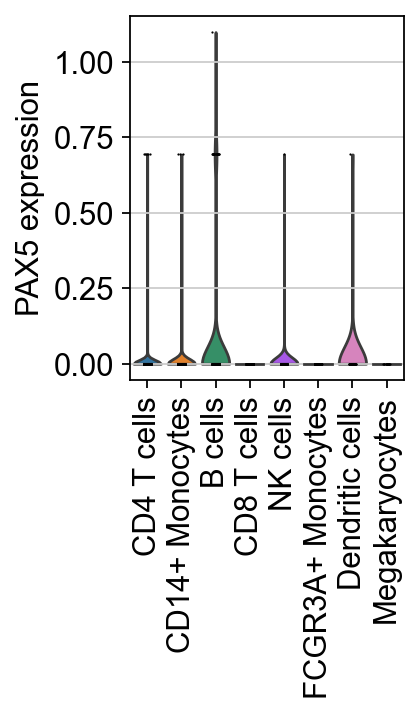

In [22]:
sc.pl.umap(adata, color=[tf, "celltype"], title=[f"{tf} expression", "celltype"])
sc.pl.violin(adata, keys=[tf], groupby="celltype", rotation=90, ylabel=f"{tf} expression")

Next, marker TFs for each cell type can be identified.

In [23]:
df = dc.tl.rankby_group(adata=score, groupby="celltype", reference="rest", method="t-test_overestim_var")
df = df[df["stat"] > 0]
df

,group,reference,name,stat,meanchange,pval,padj
9,CD4 T cells,rest,ZBTB4,33.614919,2.688046,1.054929e-195,6.392872e-194
11,CD4 T cells,rest,MYC,31.367690,2.156232,1.369677e-171,6.916871e-170
28,CD4 T cells,rest,ZBED1,24.925535,1.379326,9.114879e-121,1.904695e-119
29,CD4 T cells,rest,KLF3,24.540906,1.130052,3.574529e-118,7.220548e-117
43,CD4 T cells,rest,TRERF1,21.797367,0.628027,1.835785e-95,2.528377e-94
...,...,...,...,...,...,...,...
4840,Megakaryocytes,rest,SIM2,0.018855,0.005540,9.850910e-01,9.966029e-01
4841,Megakaryocytes,rest,TRERF1,0.012646,0.002931,9.900187e-01,9.974627e-01
4843,Megakaryocytes,rest,DLX4,0.008465,0.001910,9.933062e-01,9.974627e-01
4844,Megakaryocytes,rest,ZNF350,0.007056,0.001330,9.944218e-01,9.974627e-01


The top 3 TF markers per cell type can then be extracted.

In [24]:
n_markers = 3
source_markers = (
    df.groupby("group")
    .head(n_markers)
    .drop_duplicates("name")
    .groupby("group")["name"]
    .apply(lambda x: list(x))
    .to_dict()
)
source_markers

{'B cells': ['RFXANK', 'RFX5', 'RFXAP'],
 'CD14+ Monocytes': ['EHF', 'ONECUT1', 'ELF3'],
 'CD4 T cells': ['ZBTB4', 'MYC', 'ZBED1'],
 'CD8 T cells': ['KLF13', 'RELB', 'NFKB2'],
 'Dendritic cells': [],
 'FCGR3A+ Monocytes': ['PPARD', 'SIN3A', 'SPIC'],
 'Megakaryocytes': ['MEIS1', 'PKNOX1', 'PBX2'],
 'NK cells': ['ZGLP1', 'CEBPZ', 'ZNF395']}

The obtained markers can be plotted

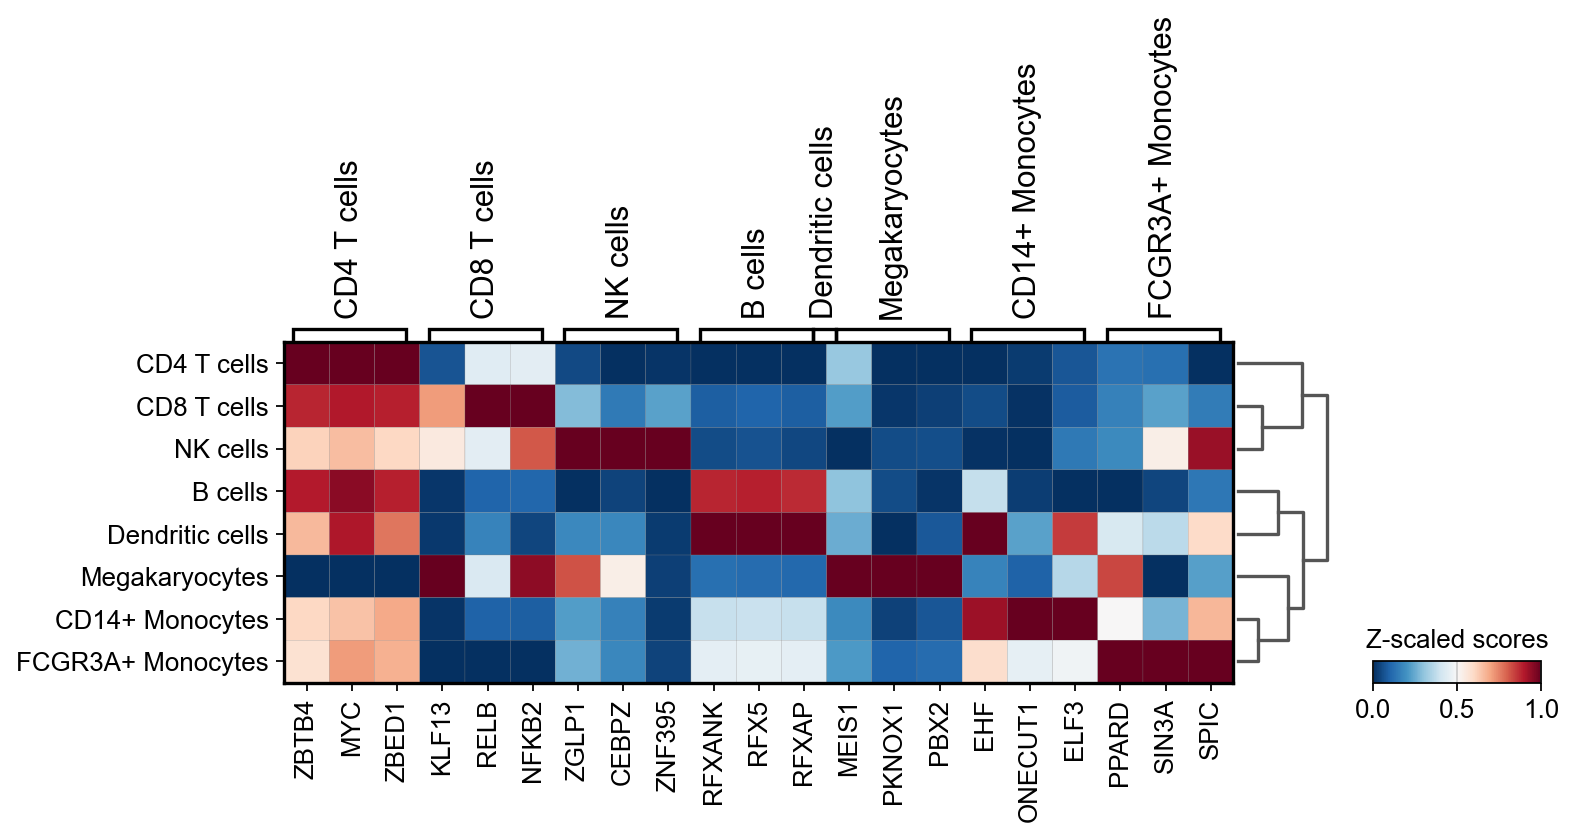

In [25]:
sc.pl.matrixplot(
    adata=score,
    var_names=source_markers,
    groupby="celltype",
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
)

Individual TFs can be examined by plotting their score distributions.

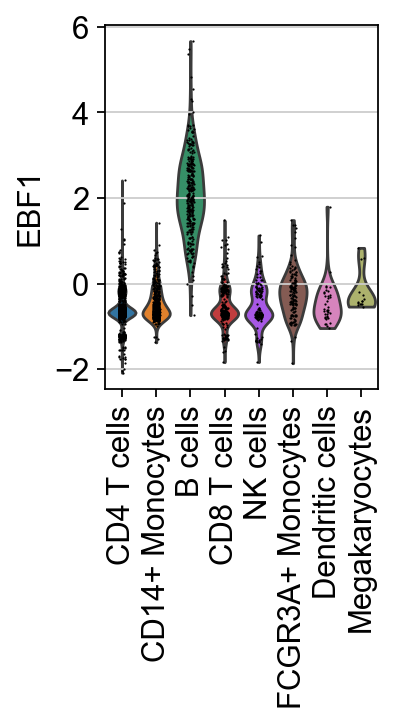

In [26]:
sc.pl.violin(score, keys=["EBF1"], groupby="celltype", rotation=90)

Here we can observe the TF activities for EBF1, which is a known marker TF for B cells.

We can also plot `collectri` to see relevant TFs and target genes for B cells:

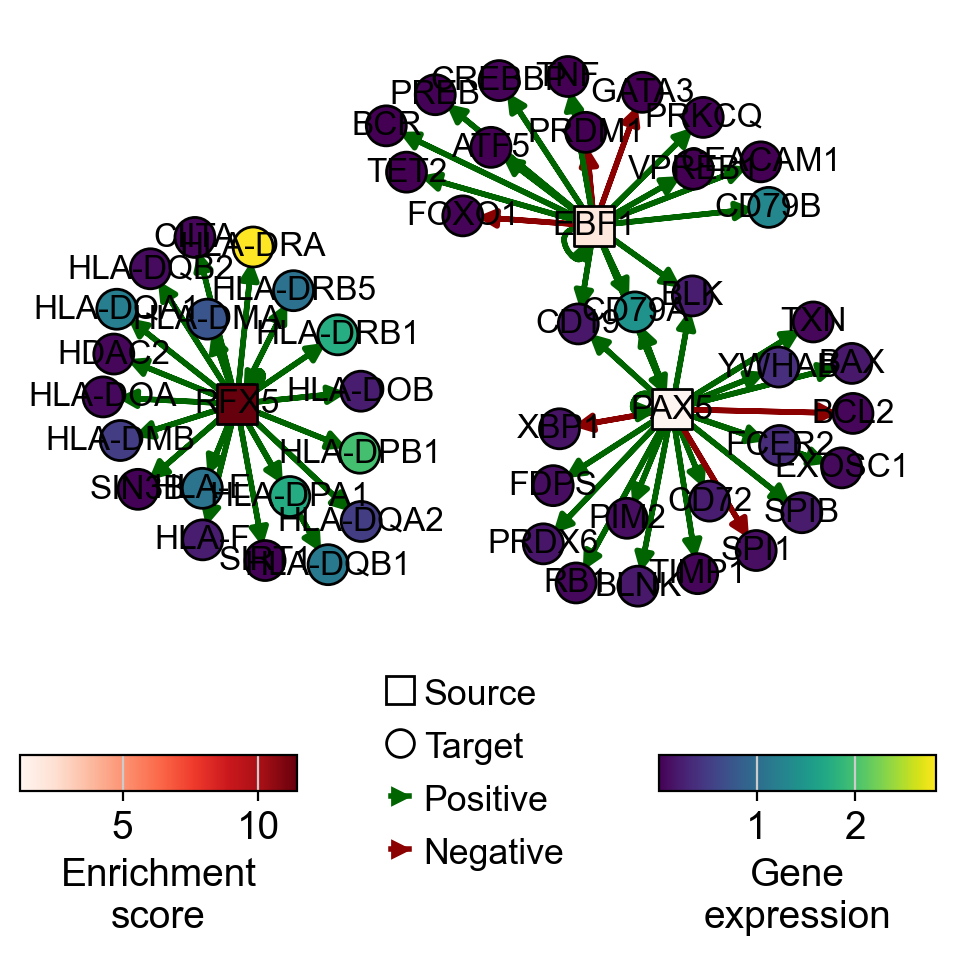

In [27]:
gex_bcells = adata[adata.obs["celltype"] == "B cells"].to_df().mean(0).to_frame().T
score_bcells = score[score.obs["celltype"] == "B cells"].to_df().mean(0).to_frame().T

dc.pl.network(
    data=gex_bcells,
    score=score_bcells,
    net=collectri,
    sources=["PAX5", "EBF1", "RFX5"],
    targets=20,
    size_node=10,
    figsize=(5, 5),
    s_cmap="Reds",
)

### Pathway Scoring

The same approach used for TF scoring can also be applied to pathways. Numerous
databases provide curated pathway gene sets, with one of the most well-known being MSigDB, which
includes several collections {cite:p}`msigdb`. 
These and many other resources can be accessed using the function {func}`decoupler.op.resource`.
To view the list of available databases, use {func}`decoupler.op.show_resources`.

#### PROGENy Pathway Genes
[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource that provides a curated
collection of pathways and their target genes, along with weights for each interaction
{cite:p}`progeny`.

Below is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation
- **MAPK**: integrates external signals and promotes cell growth and proliferation
- **NFkB**: regulates immune response, cytokine production and cell survival
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression
- **PI3K**: promotes growth and proliferation
- **TGFb**: involved in development, homeostasis, and repair of most tissues
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection
- **Trail**: induces apoptosis
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration
- **WNT**: regulates organ morphogenesis during development and tissue repair

This is how to access to it.

In [28]:
progeny = dc.op.progeny(organism="human")
progeny

,source,target,weight,padj
0,Androgen,TMPRSS2,11.490631,2.384806e-47
1,Androgen,NKX3-1,10.622551,2.205102e-44
2,Androgen,MBOAT2,10.472733,4.632376e-44
3,Androgen,KLK2,10.176186,1.944410e-40
4,Androgen,SARG,11.386852,2.790210e-40
...,...,...,...,...
62456,p53,ENPP2,2.771405,4.993215e-02
62457,p53,ARRDC4,3.494328,4.996747e-02
62458,p53,MYO1B,-1.148057,4.997905e-02
62459,p53,CTSC,-1.784693,4.998864e-02


#### Scoring
Pathway scores can be easily computed by running the `ulm` method.

In [29]:
dc.mt.ulm(data=adata, net=progeny)

Scores can be then extracted.

In [30]:
score = dc.pp.get_obsm(adata=adata, key="score_ulm")
score

AnnData object with n_obs × n_vars = 2638 × 14
    obs: 'n_genes', 'percent_mito', 'n_counts', 'celltype', 'leiden'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'leiden_colors', 'dendrogram_leiden', 'celltype_colors', 'dendrogram_celltype'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'score_ulm', 'padj_ulm'

And visualized.

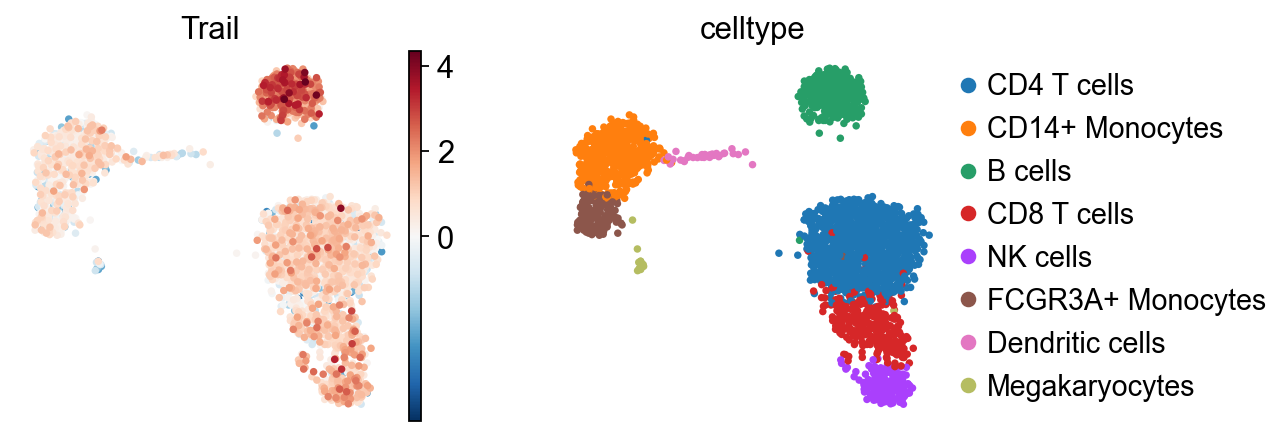

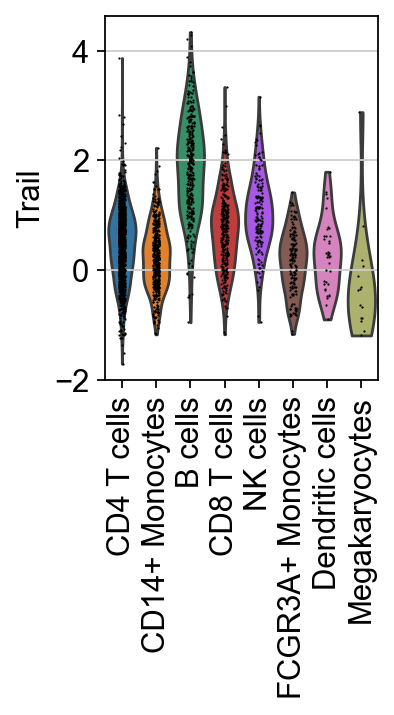

In [31]:
sc.pl.umap(score, color=["Trail", "celltype"], cmap="RdBu_r", vcenter=0)
sc.pl.violin(score, keys=["Trail"], groupby="celltype", rotation=90)

It seem that in B cells, the pathway Trail, associated with apoptosis, is more active.

Given that there are only 14 pathways, they can be directly visualized without the need for marker extraction.

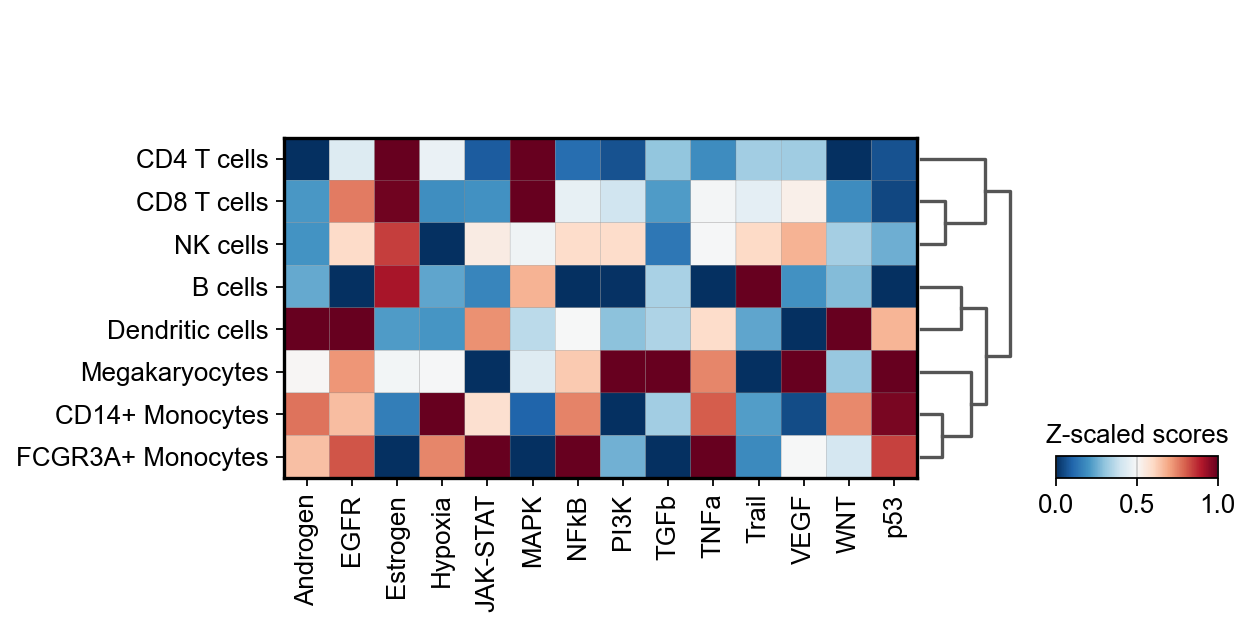

In [32]:
sc.pl.matrixplot(
    adata=score,
    var_names=score.var_names,
    groupby="celltype",
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
)

In this specific example, it can be observed that TNF-α is more active in FCGR3A+ Monocytes,
while PI3K activity is higher in Megakaryocytes.

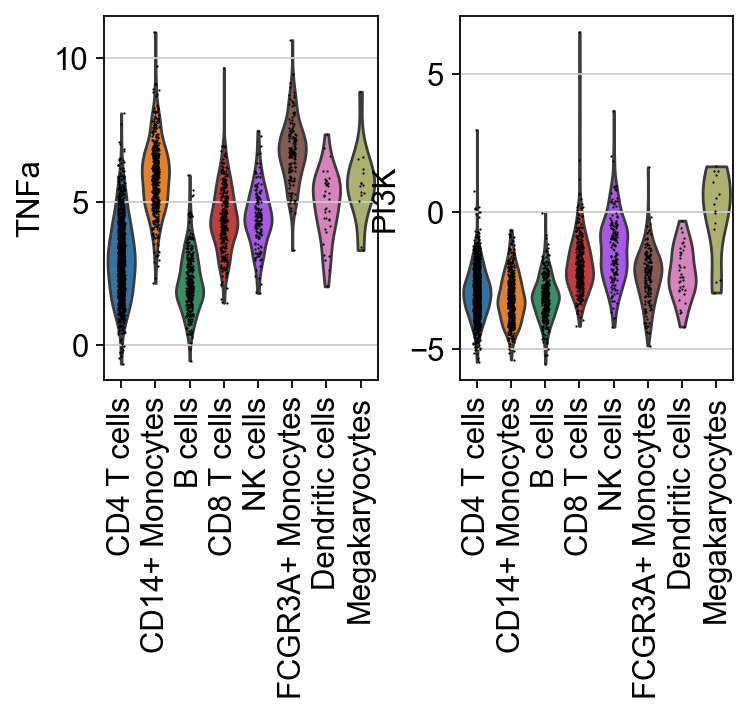

In [33]:
sc.pl.violin(score, keys=["TNFa", "PI3K"], groupby="celltype", rotation=90)

#### Hallmark gene sets
[Hallmark](https://www.gsea-msigdb.org/gsea/msigdb/human/collection_details.jsp#H)
gene sets are curated collections of genes that represent specific, well-defined biological states or processes.
They are part of MSigDB and were developed to reduce redundancy and improve interpretability compared to older,
more overlapping gene set collections {cite:p}`msigdb`.

A total of 50 gene sets are provided, designed to be non-redundant, concise, and biologically coherent.

This is how to access them.

In [34]:
hallmark = dc.op.hallmark(organism="human")
hallmark

,source,target
0,IL2_STAT5_SIGNALING,MAFF
1,COAGULATION,MAFF
2,HYPOXIA,MAFF
3,TNFA_SIGNALING_VIA_NFKB,MAFF
4,COMPLEMENT,MAFF
...,...,...
7313,PANCREAS_BETA_CELLS,STXBP1
7314,PANCREAS_BETA_CELLS,ELP4
7315,PANCREAS_BETA_CELLS,GCG
7316,PANCREAS_BETA_CELLS,PCSK2


#### Scoring
Pathway scores can be easily computed by running the `ulm` method.

In [35]:
dc.mt.ulm(data=adata, net=hallmark)

Scores can be then extracted.

In [36]:
score = dc.pp.get_obsm(adata=adata, key="score_ulm")
score

AnnData object with n_obs × n_vars = 2638 × 50
    obs: 'n_genes', 'percent_mito', 'n_counts', 'celltype', 'leiden'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'leiden_colors', 'dendrogram_leiden', 'celltype_colors', 'dendrogram_celltype'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'score_ulm', 'padj_ulm'

Next, marker gene sets for each cell type can be identified.

In [37]:
df = dc.tl.rankby_group(adata=score, groupby="celltype", reference="rest", method="t-test_overestim_var")
df = df[df["stat"] > 0]
df

,group,reference,name,stat,meanchange,pval,padj
3,CD4 T cells,rest,MYC_TARGETS_V1,21.490565,1.819335,1.590125e-92,1.987656e-91
8,CD4 T cells,rest,MYC_TARGETS_V2,17.441147,0.553157,4.855032e-64,2.697240e-63
11,CD4 T cells,rest,WNT_BETA_CATENIN_SIGNALING,16.358834,0.366900,6.704730e-57,2.793637e-56
22,CD4 T cells,rest,P53_PATHWAY,11.461240,0.493784,1.378643e-29,2.997051e-29
24,CD4 T cells,rest,E2F_TARGETS,9.503262,0.319374,5.152361e-21,1.030472e-20
...,...,...,...,...,...,...,...
391,Megakaryocytes,rest,IL2_STAT5_SIGNALING,0.436819,0.194693,6.665103e-01,7.934646e-01
392,Megakaryocytes,rest,PI3K_AKT_MTOR_SIGNALING,0.383430,0.163172,7.043131e-01,8.189688e-01
394,Megakaryocytes,rest,INFLAMMATORY_RESPONSE,0.105198,0.044449,9.169803e-01,9.828205e-01
395,Megakaryocytes,rest,WNT_BETA_CATENIN_SIGNALING,0.085780,0.013781,9.324955e-01,9.828205e-01


The top 3 set markers per cell type can then be extracted.

In [38]:
n_markers = 3
source_markers = (
    df.groupby("group")
    .head(n_markers)
    .drop_duplicates("name")
    .groupby("group")["name"]
    .apply(lambda x: list(x))
    .to_dict()
)
source_markers

{'B cells': ['KRAS_SIGNALING_DN',
  'ALLOGRAFT_REJECTION',
  'INTERFERON_GAMMA_RESPONSE'],
 'CD14+ Monocytes': ['COMPLEMENT',
  'ANGIOGENESIS',
  'EPITHELIAL_MESENCHYMAL_TRANSITION'],
 'CD4 T cells': ['MYC_TARGETS_V1',
  'MYC_TARGETS_V2',
  'WNT_BETA_CATENIN_SIGNALING'],
 'CD8 T cells': ['ANDROGEN_RESPONSE', 'APICAL_JUNCTION'],
 'Dendritic cells': ['OXIDATIVE_PHOSPHORYLATION',
  'FATTY_ACID_METABOLISM',
  'ADIPOGENESIS'],
 'FCGR3A+ Monocytes': ['COAGULATION'],
 'Megakaryocytes': [],
 'NK cells': ['INTERFERON_ALPHA_RESPONSE']}

And plotted.

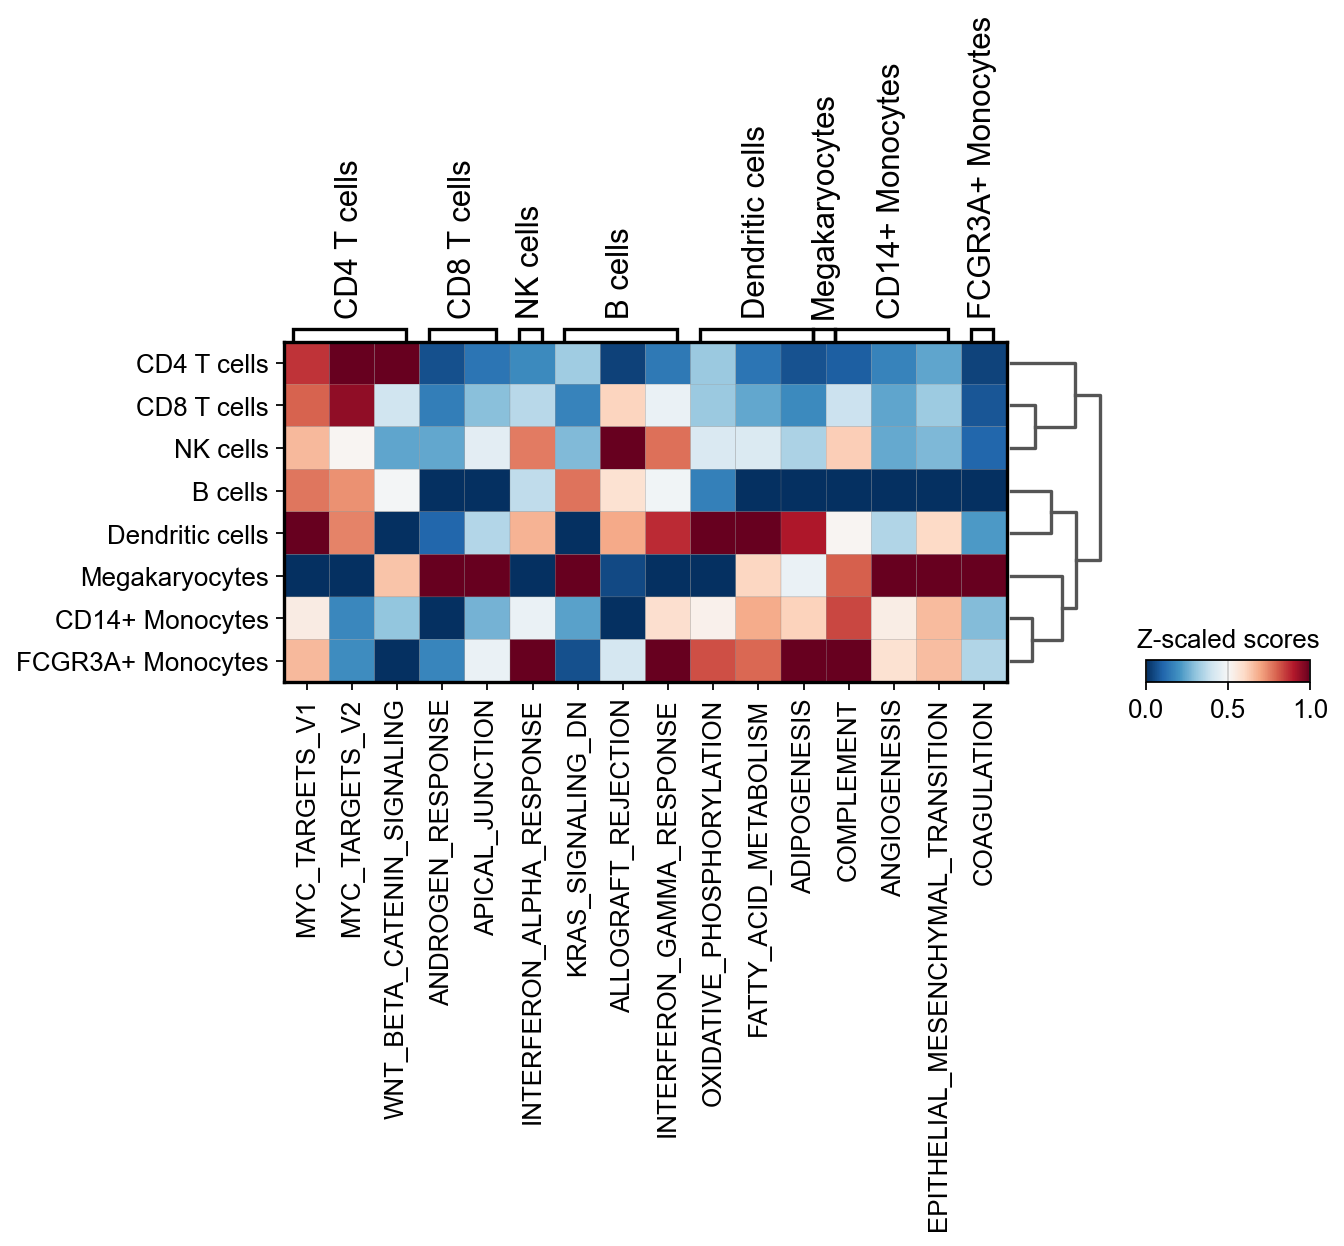

In [39]:
sc.pl.matrixplot(
    adata=score,
    var_names=source_markers,
    groupby="celltype",
    dendrogram=True,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
)